In [12]:
"""Test the radiosity.Radiosity module."""
import os

import numpy as np
import pyfar as pf
import sparapy as sp
import matplotlib.pyplot as plt
%matplotlib ipympl

In [13]:
X = 5
Y = 6
Z = 4
patch_size = 1
ir_length_s = 0.5
sampling_rate = 1000
max_order_k = 2
speed_of_sound = 343

absorption = 0.1
S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)

radiosity = sp.radiosity_fast.DRadiosityFast.from_polygon(
    walls, patch_size)
# create directivity

sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([500])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

radiosity.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)
radiosity.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))
radiosity.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))



reverberation distance is 0.5426201661567753m
reverberation time is 1.2398651513106647s


/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_28439/499828041.py:32: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity.set_wall_scattering(


In [14]:
# run simulation
print('Calculating visibility...')
radiosity.check_visibility()
print('Calculating form factors...')
radiosity.calculate_form_factors()
print('Calculating directional form factors...')
radiosity.calculate_form_factors_directivity()
print('Calculating energy exchange...')
radiosity.calculate_energy_exchange(max_order_k)


Calculating visibility...
Calculating form factors...
Calculating directional form factors...
Calculating energy exchange...


In [15]:

source_pos = np.array([2, 2, 2])

radiosity.init_energy(source_pos)

In [16]:
# test energy at receiver
receiver_pos = [
    [3, 4, 2]
    ]
histograms = []

for pos in receiver_pos:
    histograms.append(radiosity.collect_energy_receiver(
        pos, histogram_time_resolution=1/sampling_rate,
        histogram_time_length=ir_length_s).T)
irs_new = np.array(histograms).squeeze()
reverberation = pf.Signal(irs_new, sampling_rate=sampling_rate)

In [17]:
pf.plot.time(reverberation, dB=True)
irs_new.shape

(500,)

In [18]:
direct_sound_list = []
direct_analytic = []
for pos in receiver_pos:
    r = np.sqrt(np.sum((np.array(pos)-source_pos)**2))
    direct_sound = (1/(4 * np.pi * np.square(r)))
    delay_dir = int(r/speed_of_sound*sampling_rate)
    direct_analytic.append(direct_sound)
    direct_sound_list.append(pf.signals.impulse(
        reverberation.n_samples, delay_dir, direct_sound, sampling_rate).time)
direct_analytic = np.array(direct_analytic)
direct_sound = pf.Signal(
    np.array(direct_sound_list).squeeze(), sampling_rate=sampling_rate)
result = pf.utils.concatenate_channels([reverberation, direct_sound])


In [19]:
E_direct = np.sum(direct_sound.time, axis=-1)
E_reverb = np.sum(reverberation.time, axis=-1)

E_ratio = E_reverb/E_direct

E_direct_analytical = 1/(4*np.pi*r**2)
E_reverb_analytical = 4/A
E_ratio_analytical = E_reverb_analytical/E_direct_analytical

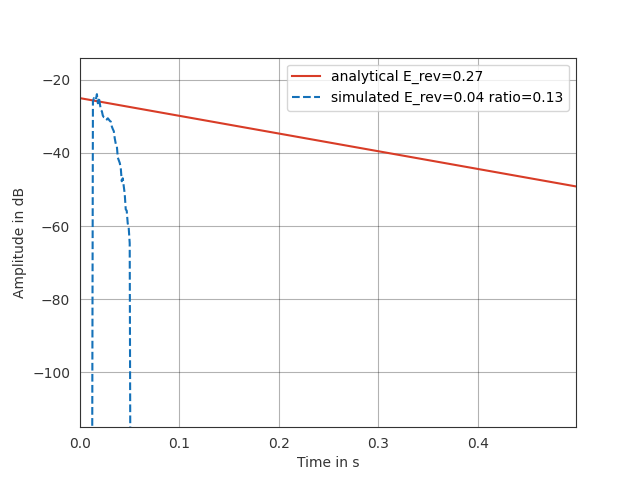

In [20]:
t = reverberation.times
w_0 = E_reverb_analytical/ V # Kuttruff Eq 4.7
t_0 = 0.03
reverberation_analytic = w_0 * np.exp(+(speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0)) # Kuttruff Eq 4.10
reverberation_analytic = pf.Signal(reverberation_analytic, sampling_rate=sampling_rate)
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}', color='r')
for i in range(len(receiver_pos)):
    e_rel = (E_reverb[i]/E_reverb_analytical)
    pf.plot.time(
        reverberation[i], dB=True, log_prefix=10,
        label=f'simulated E_rev={E_reverb[i]:0.2f} ratio={e_rel:0.2f}',
        linestyle='--')
plt.legend()
plt.show()

In [21]:
print(f'E_reverb_analytical: {E_reverb_analytical} == E_reverb: {E_reverb}')
print(f'Ratio: {E_reverb/E_reverb_analytical}')
# print(f'E_direct_analytical: {direct_analytic} == E_direct: {E_direct}')
print(f'Ratio mean: {E_reverb_analytical/np.mean(E_reverb)}')

E_reverb_analytical: 0.27027027027027023 == E_reverb: [0.03611244]
Ratio: [0.13361603]
Ratio mean: 7.484131932984495


In [22]:
data_scattering.frequencies

array([500])